# Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Sklearn Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

# Setup plotting
sns.set_style("whitegrid")

# Create models folder if it doesn't exist
if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 1. Target Definition & Cleaning
We are predicting **Overcost** (Market Efficiency).

* **Goal:** Predict if a campaign will be under or over budget based on its settings.
* **Formula:** `Overcost = approved_budget - media_cost_usd`
    * **Positive (+):** Under Budget (Good efficiency).
    * **Negative (-):** Over Budget (Bad efficiency).
* **Critical Step:** We MUST drop `approved_budget` and `media_cost_usd` from the input features (X). If we include them, the model will "cheat" by simply doing the subtraction itself (Data Leakage).

In [ ]:
# FIND FILE AUTOMATICALLY
files = glob.glob("../Cleaned_Datasets/Marketing/*.csv")

if len(files) == 0:
    print("❌ Error: No files found. Check your directory path!")
else:
    print(f"Loading file: {files[0]}")
    df = pd.read_csv(files[0])

    # 1. CREATE TARGET (if not exists)
    if 'Overcost' not in df.columns:
        print("Creating 'Overcost' column...")
        budget_col = 'approved_budget' 
        cost_col = 'media_cost_usd'
        
        # Force numeric conversion to avoid string errors
        df[budget_col] = pd.to_numeric(df[budget_col], errors='coerce')
        df[cost_col] = pd.to_numeric(df[cost_col], errors='coerce')
        
        # Calculate Target
        df['Overcost'] = df[budget_col] - df[cost_col]

    TARGET = 'Overcost'

    # 2. DROP LEAKAGE & IDs
    leakage = ['approved_budget', 'campaign_budget_usd', 'media_cost_usd', 'campaign_item_id']
    df = df.drop([c for c in leakage if c in df.columns], axis=1)

    # Encode Categoricals
    df = pd.get_dummies(df, drop_first=True)
    df = df.fillna(0)

    print(f"Final Data Shape: {df.shape}")

Loading file: ../Cleaned_Datasets/Marketing\marketing_cleaned_prepared.csv
Creating 'Overcost' column...
Final Data Shape: (72206, 240)


## 2. Feature Selection
We analyze which campaign settings (Day, Category, Platform, etc.) have the biggest impact on the cost.
* **Visual Check:** Correlation Heatmap.
* **Statistical Check:** `SelectKBest` scores.

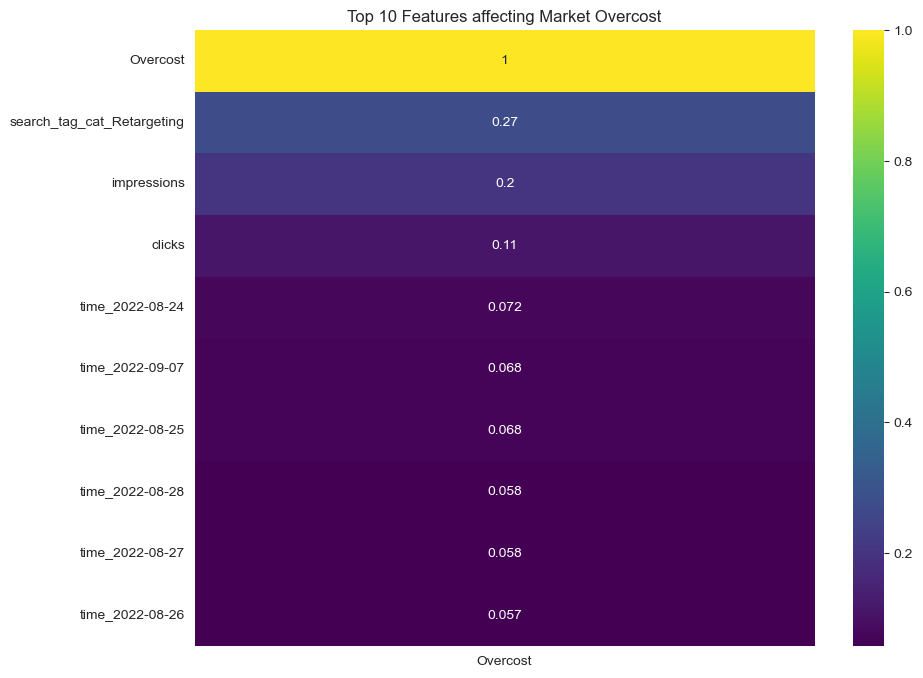

✅ Column names sanitized for LightGBM.
Top 5 Most Important Features:
search_tag_cat_Retargeting    5743.973850
impressions                   3101.237043
no_of_days                     990.112648
clicks                         907.521755
time_2022_08_24                379.276832
dtype: float64
Top 5 Most Important Features:
search_tag_cat_Retargeting    5743.973850
impressions                   3101.237043
no_of_days                     990.112648
clicks                         907.521755
time_2022_08_24                379.276832
dtype: float64


In [9]:
# Visualize Top features impacting Cost
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr[[TARGET]].sort_values(by=TARGET, ascending=False).head(10), annot=True, cmap='viridis')
plt.title("Top 10 Features affecting Market Overcost")
plt.show()

# Separate Features and Target
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# This block removes special characters (like brackets, spaces, colons) from column names
# so LightGBM doesn't crash.

X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]
print("✅ Column names sanitized for LightGBM.")
# ==============================================================================

# 2. Statistical Importance
selector = SelectKBest(score_func=f_regression, k='all') 
selector.fit(X, y)
scores = pd.Series(selector.scores_, index=X.columns)

print("Top 5 Most Important Features:")
print(scores.nlargest(5))

# Statistical Importance
selector = SelectKBest(score_func=f_regression, k='all') 
selector.fit(X, y)
scores = pd.Series(selector.scores_, index=X.columns)

print("Top 5 Most Important Features:")
print(scores.nlargest(5))

## 3. Baseline Model Comparison
We train our three regressors to predict the `Overcost`.
* **Metric:** We use **RMSE (Root Mean Squared Error)**.
* **Interpretation:** Lower RMSE is better. It represents how many dollars ($) our prediction is off by on average.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

best_rmse = float('inf') # Lower is better for Cost prediction
best_model_name = ""
best_base_model = None

print(f"{'Model':<15} | {'RMSE (Lower is Better)':<25}")
print("-" * 45)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{name:<15} | {rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name
        best_base_model = model

print(f"\n🏆 Winner: {best_model_name}")

Model           | RMSE (Lower is Better)   
---------------------------------------------
RandomForest    | 118623.2481
XGBoost         | 250796.5554
LightGBM        | 228474.4521

🏆 Winner: RandomForest


## 4. Optimization & Saving
We take the winning model and tune its hyperparameters to see if we can reduce the error (RMSE) further.
Finally, we save the model using `joblib` with a versioned filename.

In [11]:
# Simple Optimization for the winner
param_grids = {
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, None]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
}

print(f"Optimizing {best_model_name}...")

if best_model_name in param_grids:
    search = RandomizedSearchCV(best_base_model, param_grids[best_model_name], n_iter=5, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_opt_model = search.best_estimator_
else:
    best_opt_model = best_base_model

# Check Score
y_pred_opt = best_opt_model.predict(X_test)
opt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_opt))
print(f"Optimized RMSE: {opt_rmse:.4f}")

# SAVE
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"Engine_B_Market_{best_model_name}_RMSE-{opt_rmse:.2f}_{timestamp}.joblib"
# Ensure the path is correct relative to where you run this notebook
save_dir = "../models" if os.path.isdir("../models") else "../../models"
if not os.path.exists(save_dir): os.makedirs(save_dir)

save_path = os.path.join(save_dir, filename)

joblib.dump(best_opt_model, save_path)
print(f"✅ Model saved: {save_path}")

Optimizing RandomForest...


c:\Users\gonal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimized RMSE: 119272.7070
✅ Model saved: ../models\Engine_B_Market_RandomForest_RMSE-119272.71_20260110_1841.joblib
